In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


## Load Data

In [2]:
path = 'data/'
EMBEDDING_FILE='data/glove.6B.50d.txt'
TRAIN_DATA_FILE='data/train.csv'
TEST_DATA_FILE='data/test.csv'
CLEAN_TRAIN_FILE='data/clean_nltk2.csv'

In [3]:
embed_size = 50
max_features = 20000
maxlen = 100

In [4]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

In [5]:
clean_train = pd.read_csv(CLEAN_TRAIN_FILE, header=None, index_col=0)

In [6]:
train.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [7]:
train.shape

(159571, 8)

In [8]:
clean_train.columns = ['clean_comment_text']
clean_train.head()

clean_comment_text
0                                                   
0  ExplanationWhy edit make username Hardcore Met...
1  D'aww ! He match background colour I'm seeming...
2  Hey man , I'm really try edit war . It's guy c...
3  " MoreI cannot make real suggestions improveme...
4  You , sir , hero . Any chance remember page th...

In [9]:
clean_train.shape

(312735, 1)

In [10]:
train['clean_comment_text'] = clean_train['clean_comment_text'][:159571]

In [21]:
train.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  \
0             0        0       0       0              0   
1             0        0       0       0              0   
2             0        0       0       0              0   
3             0        0       0       0              0   
4             0        0       0       0              0   

                                  clean_comment_text  
0  ExplanationWhy edit make username Hardcore Met...  
1  D'aww ! He match background colour I'm seeming...  
2  Hey man , I'm really try edit war . It's guy c...  
3  " MoreI cannot make real suggestions improveme...  
4  You , sir , hero . Any chance remember page th...

In [22]:
test['clean_comment_text'] = clean_train['clean_comment_text'][159571:]

In [23]:
test.head()

id                                       comment_text  \
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...   
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...   
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...   
3  00017563c3f7919a  :If you have a look back at the source, the in...   
4  00017695ad8997eb          I don't anonymously edit articles at all.   

                                  clean_comment_text  
0  Yo bitch Ja Rule succesful you will ever whats...  
1            = = From RfC = = The title fine , IMO .  
2      " = = Sources = = * Zawe Ashton Lapland — / "  
3  : If look back source , information I update c...  
4                I do not anonymously edit article .

### Undersampleing

In [24]:
count_toxic_0, count_toxic_1 = train['toxic'].value_counts()

In [25]:
toxic_0 = train[train['toxic'] == 0]
toxic_1 = train[train['toxic'] == 1]

#### Random under-sampling

In [26]:
toxic_0_under = toxic_0.sample(count_toxic_1)
train_under = pd.concat([toxic_0_under, toxic_1], axis=0)

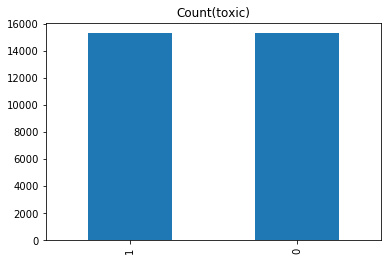

In [27]:
train_under.toxic.value_counts().plot(kind='bar', title='Count(toxic)')

In [28]:
train_under.head()

id                                       comment_text  \
131209  be132c68a0caab7d  "\n\n Hello \n\nI wanted to let you know that ...   
10624   1c0bea7da31dbf2e  About irfca.org permission \n\nI found you hav...   
1903    052a64799702b6b6  Summaries \n\nSorry bout that... I'll try to r...   
24895   41d77f6ae34051ff  Need help?  What are you trying to AfD and why...   
34045   5ad2e6d230a99329  I have deleted the compete section.   (talk - ...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  \
131209      0             0        0       0       0              0   
10624       0             0        0       0       0              0   
1903        0             0        0       0       0              0   
24895       0             0        0       0       0              0   
34045       0             0        0       0       0              0   

                                       clean_comment_text  
131209  " Hello I want let know I revert essentially c...  
10624   About irfca.org permission I find mention irfc...  
1903    Summaries Sorry bout ... I'll try remember bet...  
24895   Need help ? What try AfD ? I'll show AfD Prod ...  
34045      I delete compete section . ( talk - contribs )

### Fill NA

In [29]:
list_sentences_train = train_under["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_under[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

### Tokenize

In [30]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [31]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [32]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940464, 0.64410418)

### Embedding and Build model

In [33]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [34]:
print(embedding_matrix.shape)

(20000, 50)


In [35]:
np.save('data/glove_matrix.npy',embedding_matrix)

In [36]:
np.load('data/glove_matrix.npy')

array([[  2.28829253e-01,  -3.02131168e-01,   2.73144714e-01, ...,
         -4.48769757e-01,  -4.23780676e-01,   4.56218952e-01],
       [  4.18000013e-01,   2.49679998e-01,  -4.12420005e-01, ...,
         -1.84110001e-01,  -1.15139998e-01,  -7.85809994e-01],
       [ -1.09190005e-03,   3.33240002e-01,   3.57430011e-01, ...,
         -4.56970006e-01,  -4.89690006e-02,   1.13160002e+00],
       ..., 
       [  3.57600003e-01,   1.63629994e-01,   2.86040008e-01, ...,
          6.28910005e-01,   1.51659995e-01,  -1.06810004e-01],
       [ -3.86339992e-01,   3.27850014e-01,   6.58089966e-02, ...,
         -3.85289997e-01,  -5.71519971e-01,   7.12360024e-01],
       [  6.11400008e-02,   1.08429998e-01,   2.67410010e-01, ...,
         -2.51170009e-01,  -5.40589988e-01,   1.88970007e-02]])

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.fit(X_t, y, batch_size=32, epochs=6, validation_split=0.1)

In [57]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv('data/submission_word2vec.csv', index=False)

153164/153164 [==============================] - 261s 2ms/step


#### 加载tf-idf矩阵

In [2]:
word2vec_matrix = np.load('data/word2vec.npy')
print(word2vec_matrix.shape)

NameError: name 'np' is not defined

In [21]:
embed_size_2 = 100
max_features_2 = 144
maxlen_2 = 100

In [ ]:
inp_2 = Input(shape=(maxlen_2,))
x_2 = Embedding(max_features_2, embed_size_2, weights=[word2vec_matrix])(inp_2)
x_2 = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x_2)
x_2 = GlobalMaxPool1D()(x)
x_2 = Dense(50, activation="relu")(x_2)
x_2 = Dropout(0.1)(x_2)
x_2 = Dense(6, activation="sigmoid")(x_2)
model_2 = Model(inputs=inp_2, outputs=x_2)
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model_2.fit(X_t, y, batch_size=32, epochs=6, validation_split=0.1)

#### 加载tf-idf矩阵

In [ ]:
bi_train_matrix = np.load('bi_train_matrix.npy')
print(bi_train_matrix.shape)